# Реализация логистической регрессии в TensorFlow

In [1]:
import numpy as np
import tensorflow as tf

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt

## Генерируем данные для задачи регрессии

In [3]:
NUM_FEATURES = 2
NUM_SAMPLES = 1000

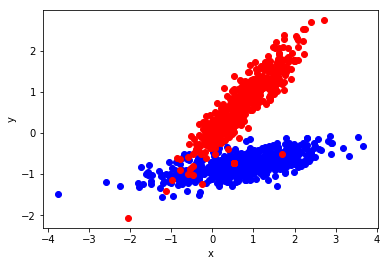

In [4]:
from sklearn.datasets import make_classification

X, y = make_classification(n_samples = NUM_SAMPLES,#семплов
                           n_features = NUM_FEATURES,#признаков
                           n_informative = NUM_FEATURES,#измерений
                           n_redundant = 0,#кол-во избыточных фичей
#The number of redundant features. These features are generated as random linear combinations of the informative features
                           n_classes = 2,#классов
                           n_clusters_per_class = 1,# по одному кластеру на класс
                           class_sep = 0.75,# на сколько классы пересекаются между собой
                           random_state = 54312)

y = y.reshape(-1, 1)

ones = np.where(y == 1)   # индексы объектов класса '1'
zeros = np.where(y == 0)  # индексы объектов класса '0'

plt.xlabel('x')
plt.ylabel('y')
plt.plot(X[ones, 0], X[ones, 1], 'ob',
         X[zeros, 0], X[zeros, 1], 'or');

## Вспомогательная функция для создания операций

In [5]:
import string
#string модуль Python предоставляет константы для операций, связанных с строкой
#IN: string.ascii_letters
#OUT: 'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ'


def py_func_with_grad(func, inp, Tout, grad, name = None, stateful = False, graph = None):
    """Функция для регистрации операций"""
    ## Необходимо создать уникальное имя, чтобы избежать дублирования, например:
    #'ra_qa_va_Ea_Ia_Ba_qa_Ea_Va_x'
    name_prefix = ''.join(np.random.choice(list(string.ascii_letters), size = 10))
    
    name = '%s_%s' % (name_prefix, name or '') #не совсем понятно, что тут происходит
    #добавляем к имени операции строку спереди, например получается:
    #'ra_qa_va_Ea_Ia_Ba_qa_Ea_Va_x__grad'
    grad_func_name = '%s_grad' % name

    tf.RegisterGradient(grad_func_name)(grad) #Этот декоратор используется только при определении 
    #нового типа операции. Для ОП с m входов и n выходов функция градиента является функцией 
    #которая берет исходные  Operation и n тензоров (представление градиентов по отношению к каждому выходу операции), и возвращает m объектов Tensor
    #(представляющие частичные градиенты по отношению к каждому входу операций)...

    g = graph or tf.get_default_graph() #Возвращает график по умолчанию для текущего потока...
    with g.gradient_override_map({'PyFunc': grad_func_name, #Экспериментальный: менеджер контекста для переопределения функций градиента
                                  'PyFuncStateless': grad_func_name}):
        with tf.name_scope(name, 'PyFuncOp', inp): #Возвращает диспетчер контекста, который создает иерархические имена для операций
            #py_func сворачивает питоновскую функцию и используем ее как операцию TensorFlow...
            return tf.py_func(func, inp, Tout, stateful = stateful, name = name)

## Реализация линейной опреаций

In [6]:
def linear_op_forward(X, W):
    ''' Реализация линейной операции '''
    return np.dot(X, W.T)  # аргументы являются numpy-массивами, транспонируем веса и перемножаем с 
#матрицей признаков

def linear_op_backward(op, grads):
    ''' Реализация вычисления градиента линейной операции '''
    X = op.inputs[0]  # тензор входных данных
    W = op.inputs[1]  # тензор параметров модели
    dX = tf.multiply(grads, W) #Возвращает X * y по элементам.
    dW = tf.reduce_sum(tf.multiply(X, grads), #Вычисляет сумму элементов по измерениям тензора
                       axis = 0,
                       keep_dims = True)
    return dX, dW





In [7]:
def sigmoid_op_forward(X):
    # TODO: реализовать операцию sigmoid
    return 1/(1+np.exp(-X))

In [8]:
def sigmoid_op_backward(op, grads):
    # TODO: реализовать вычисление градиента для sigmoid (вспомнить как выглядит производная для сигмоиды)
    y_pred = op.inputs[0]  # тензор входных данных
    gradient = tf.multiply(tf.sigmoid(y_pred),tf.subtract(tf.constant(1.0),tf.sigmoid(y_pred)))
    d = tf.multiply(grads, gradient)
    
    return d

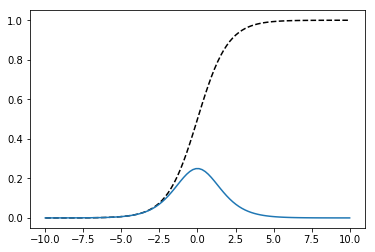

In [9]:
# посмотрим на график сигмоиды и ее производной
i = np.linspace(-10,10,100)

fig = plt.figure()
plt.plot(i, 1/(1+np.exp(-i)), '--', color='k')
plt.plot(i, (np.e**-i)/(1+np.e**-i)**2);

## Создание графа вычислений и обучение модели

In [10]:
BATCH_SIZE = NUM_SAMPLES // 10
EPOCHS = 30

weights = None  # в этой переменной мы сохраним результат обучения модели
learning_curve = []  # значения ошибки на каждой итерации обучения

with tf.Session(graph = tf.Graph()) as sess:  # инициализируем сессию вычислений
    
    # создаем placeholdr'ы, через них мы будем
    # передавать внешние данные в граф вычислений
    plh_X = tf.placeholder(dtype = tf.float32, shape = [None, NUM_FEATURES])
    plh_labels = tf.placeholder(dtype = tf.float32, shape = [None, 1])

    # создаем переменную для хранения весов модели
    # эти веса будут изменяться в процессе обучения
    var_W = tf.Variable(tf.random_uniform(shape = [1, NUM_FEATURES],
                                          dtype = tf.float32,
                                          seed = 54321))
    
    # создаем переменную для результата предсказания модели
    var_Pred = py_func_with_grad(linear_op_forward,         # функция предсказания модели 
                                 [plh_X, var_W],            # аргументы функции
                                 [tf.float32],              # тип выходных значений
                                 name = 'linear_op',        # имя операции 
                                 grad = linear_op_backward, # функция для вычисления градиента
                                 graph = sess.graph)        # объект графа вчислений
    
    # создаем переменную для результата операции sigmoid
    var_Sigmoid = py_func_with_grad(sigmoid_op_forward,
                                    [var_Pred],
                                    [tf.float32],
                                    name = 'sigmoid_op',
                                    grad = sigmoid_op_backward,
                                    graph = sess.graph)
    
    # кроссэнтропийная функция потерь для бинарной классификации
    cost = tf.losses.sigmoid_cross_entropy(plh_labels, var_Sigmoid)
    
    # инициализируем оптимизатор и указываем скорость обучения
    optimizer = tf.train.GradientDescentOptimizer(learning_rate = 0.9).minimize(cost)

    # инициализируем placeholder'ы и переменные
    sess.run(tf.global_variables_initializer())
    
    indices = np.arange(len(X))  # массив индексов объектов
    
    # выполняем итерации по 10-ти эпохам
    for epoch in range(EPOCHS):
        
        # вначале каждой эпохи перемешиваем индексы
        np.random.shuffle(indices)
        
        # внутри каждой эпохи данные разбиваются на батчи
        for batch in range(len(X) // BATCH_SIZE):
            
            # выбираем индексы очередного батча
            batch_indices = indices[batch * BATCH_SIZE:(batch + 1) * BATCH_SIZE]

            # выполняем шаг обучения: вычисляем ошибку и обновляем веса
            loss, _ = sess.run([cost, optimizer],  # указываем, какие операции необходимо выполнить
                               feed_dict = {plh_X: X[batch_indices],  # передаем входные данные для вычисления
                                            plh_labels: y[batch_indices]})
        
            # сохраняем значения ошибки для построения кривой обучения
            learning_curve.append(loss)
            
            # выводим текущее значение ошибки для каждого 10го шага
            steps = len(learning_curve) - 1
            if steps % 10 == 0:
                print('[%03d] loss=%.3f weights=%s' % (steps, loss, var_W.eval()))
    
    # сохраняем обученные веса
    weights = var_W.eval()

W0702 22:32:49.669583  9724 deprecation.py:323] From <ipython-input-5-554c895b33fa>:28: py_func (from tensorflow.python.ops.script_ops) is deprecated and will be removed in a future version.
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    
W0702 22:32:49.688572  9724 deprecation.py:323] From C:\Users\User\Anaconda3\lib\site-packages\tensorflow\python\ops\nn_impl.py:180: add

[000] loss=0.737 weights=[[0.41545174 0.18943205]]
[010] loss=0.644 weights=[[ 0.17594436 -0.58728135]]
[020] loss=0.628 weights=[[ 0.0374533 -1.1963044]]
[030] loss=0.619 weights=[[ 0.02980042 -1.6122472 ]]
[040] loss=0.599 weights=[[ 0.04252826 -1.9426028 ]]
[050] loss=0.595 weights=[[ 0.07291123 -2.20947   ]]
[060] loss=0.599 weights=[[ 0.09532239 -2.436526  ]]
[070] loss=0.599 weights=[[ 0.11886613 -2.6296544 ]]
[080] loss=0.615 weights=[[ 0.1364131 -2.8076236]]
[090] loss=0.576 weights=[[ 0.16380824 -2.960268  ]]
[100] loss=0.536 weights=[[ 0.17336091 -3.1029403 ]]
[110] loss=0.579 weights=[[ 0.1905931 -3.2328968]]
[120] loss=0.586 weights=[[ 0.20633925 -3.352056  ]]
[130] loss=0.555 weights=[[ 0.22244355 -3.4585056 ]]
[140] loss=0.574 weights=[[ 0.23199542 -3.5645351 ]]
[150] loss=0.573 weights=[[ 0.23738086 -3.662799  ]]
[160] loss=0.558 weights=[[ 0.2451892 -3.7530107]]
[170] loss=0.562 weights=[[ 0.25131783 -3.8382044 ]]
[180] loss=0.544 weights=[[ 0.26244617 -3.9216335 ]]
[19

## Визуализируем кривую обучения

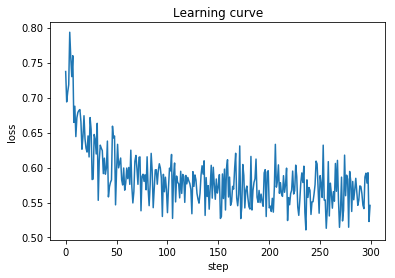

In [11]:
plt.xlabel('step')
plt.ylabel('loss')
plt.title('Learning curve')
plt.plot(learning_curve);

## Визуализируем разделяющую гиперплоскость

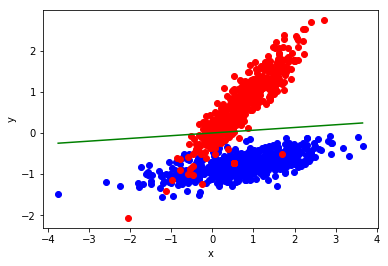

In [12]:
y_pred = - X[:, 0] * weights[0, 0] / weights[0, 1]

order = np.argsort(X[:, 0])

plt.xlabel('x')
plt.ylabel('y')
plt.plot(X[ones, 0], X[ones, 1], 'ob',
         X[zeros, 0], X[zeros, 1], 'or',
         X[order, 0], y_pred[order], '-g');

In [13]:
weights

array([[ 0.30980787, -4.667698  ]], dtype=float32)

In [14]:
X.shape

(1000, 2)

In [15]:
# результат не очень впечатляет